# Homework4 [Project] 
#### Data Science in Korea University, Prof. Jaewoo Kang
#### COSE471, Spring 2018
#### Due : 6/26 (Tues)  11:59 PM [NO LATE HAND IN(Late hand in will get 0), because of school grade policy]

### In this assignment, you will design, implement, and evaluate the appropriate models for given data.
- __This is project assignment. We can not reply your questions about technical(code) issues.__
- __이번 과제는 프로젝트 과제입니다. 소스코드와 같은 기술적인 질문에는 답변 드릴 수 없습니다.__

<br>
<br>
*Perform the steps described below for each dataset(2 Project).*
>0. Preprocess; normalization, feature selection, etc.
>1. Model selection; characteristics of datasets need to be comprehended.
>2. Evaluation; This step should be done properly to prevent overfitting problem.
>3. Enhancement; parameter tuning and feature selection, etc.

### When you make your model for this Project, you should use scikit learn. Don't use other ML package.
### Of course you can use any packages for handling your data. (pandas, numpy, matplotlib, random etc.)
### Download your data in *https://www.dropbox.com/sh/6s4e0z9fhenfw6z/AADkJO3Z6WN1b8IJhkVp9KgDa?dl=0*

## Project 1
### h1b data [h1b_train, h1b_dev, h1b_test]

- Use h1b __train data__ for train your model.
- Tune your model with __dev data__.
- Finally check your best performed model score with __test data__.
- __*You should clean your train dev test data first!!*__
- Score function : Accuracy
<br>
<br>
- __Your goal is to predict CASE_STATUS, using other features.__
- You can choose the features you want to use in your project.

### Attribute Information

- __CASE_STATUS__
    - The CASE_STATUS field denotes the status of the application after LCA processing. Certified applications are filed with USCIS for H-1B approval.
<br>
<br>
- EMPLOYER_NAME
    - Name of the employer submitting labor condition application.
<br>
<br>
- SOC_NAME
    - Occupational name associated with the SOC_CODE. SOC_CODE is the occupational code associated with the job being requested for temporary labor condition, as classified by the Standard Occupational Classification (SOC) System.
<br>
<br>
- JOB_TITLE
    - Title of the job.
<br>
<br>
- FULL_TIME_POSITION
    - Y = Full Time Position; N = Part Time Position.
<br>
<br>
- PREVAILING_WAGE
    - Prevailing Wage for the job being requested for temporary labor condition. The wage is listed at annual scale in USD. The prevailing wage for a job position is defined as the average wage paid to similarly employed workers in the requested occupation in the area of intended employment. The prevailing wage is based on the employer’s minimum requirements for the position.
<br>
<br>
- YEAR
    - Year in which the H-1B visa petition was filed.
<br>
<br>

In [31]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import copy

train_name = 'h1b_train.csv'
test_name = 'h1b_test.csv'
dev_name = 'h1b_dev.csv'

In [32]:
def get_param(train, dev) : 
        
    case_status = "CASE_STATUS"

    train_df = pd.read_csv(train)
    valid_df = pd.read_csv(dev)
    
    df = pd.concat([train_df, valid_df])
    
    df = df.dropna(axis = 0)
    
    labels = set(x for x in df.loc[:, case_status])
    
    label_dict = {}
    for i, x in enumerate(labels) :
        label_dict[x] = i
    
    #print(label_dict)

    F_max = df.loc[:, 'PREVAILING_WAGE'].max()
    F_min = df.loc[:, 'PREVAILING_WAGE'].min()

    lat_max = df.loc[:, 'lat'].max()
    lat_min = df.loc[:, 'lat'].min()

    lon_min = df.loc[:, 'lon'].min()
    lon_max = df.loc[:, 'lon'].max()

    year_max = df.loc[:, 'YEAR'].max()
    year_min = df.loc[:, 'YEAR'].min()
    
    country = set(x.split(',')[-1] for x in df.loc[:, 'WORKSITE'])
    
    work_dic ={}
    
    for i, x in enumerate(country) :
        work_dic[x] = i

    param_list = {'label' : label_dict, 'F':[F_max, F_min], 'lon' :[lon_max, lon_min], 'lat': [lat_max, lat_min], 'year' : [year_max, year_min], "worksite" : work_dic}
    
    
    
    #print(datas)
    
    return param_list

In [33]:
def get_data(name, param_list = None) :
    df = pd.read_csv(name)
    
    df = df.dropna(axis = 0)
    
    case_status = "CASE_STATUS"
    x_name_list = ['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR', "lon", 'lat', 'WORKSITE']
    
    labels = df.loc[:, case_status].values.tolist()
    datas = df.loc[:, x_name_list].values.tolist()
    
    return labels, datas

In [34]:
def data_process(labels, datas, param_list, test=False) :
    """
    return data_list  =  featured vector set
    """
    pro_labels = labels
    pro_datas = datas
    
    label_dic = param_list['label']
    if not test : 
        for i, label in enumerate(pro_labels):
            pro_labels[i] = label_dic[label]
    else :
        for i, label in enumerate(pro_labels):
            try :
                pro_labels[i] = label_dic[label]
            except :
                pro_labels[i] = -1
    
    F = param_list["F"]
    F_scale = F[0] - F[1]
    
    lon = param_list["lon"]
    lon_scale = lon[0] - lon[1]

    lat = param_list["lat"]
    lat_scale = lat[0] - lat[1]

    year = param_list['year']
    year_scale = year[0] - year[1]  
    
    work_dic = param_list['worksite']
    scaler = len(work_dic)
    
    for data in pro_datas :
        if data[0] == 'Y' :
            data[0] = 1
        else :
            data[0] = 0

        data[1] = ((data[1] - F[1])/F_scale)*scaler

        data[2] = ((data[2] - year[1])/year_scale)*scaler

        data[3] = ((data[3] - lon[1])/lon_scale)*scaler

        data[4] = ((data[4] - lat[1])/lat_scale)*scaler
        
        data[5] = work_dic[data[5].split(',')[-1]]
        
    return pro_labels, pro_datas

In [35]:
def get_batch(labels, datas, batch_size) :
    devide = int(len(labels)/batch_size )
    
    batch = []
    
    for i in range(devide) :    
        if (i+1)*devide > len(labels) :
            batch.append([labels[i*devide:len(labels)], datas[i*devide:len(labels)]])
        else :
            batch.append([labels[i*devide:(i+1)*devide], datas[i*devide:(i+1)*devide]])
    
    return batch
    

In [41]:
## data_setting
param_list = get_param(train_name, dev_name)

train_label, train_data = get_data(train_name)
valid_label, valid_data = get_data(dev_name)
test_label, test_data = get_data(test_name)
print('data_load')
print(len(train_data))
print(len(valid_data))
print(len(test_data))

train_label, train_data = data_process(train_label, train_data, param_list)
valid_label, valid_data = data_process(valid_label, valid_data, param_list)
test_label, test_data = data_process(test_label, test_data, param_list, test=True)
print('data_process')

flag = None
if len(valid_label) < len(test_label) :
    temp = len(valid_label)
    flag = 'dev'
else :
    temp = len(test_label)
    flag = 'test'
    
tot = int(len(train_label)/temp)

if flag == 'dev' :
    train_label = train_label[:len(valid_label)*tot]
    train_data = train_data[:len(valid_data)*tot]
    test_label = test_label[:len(valid_label)]
    test_data = test_data[:len(valid_data)]
else :
    train_label = train_label[:len(test_label)*tot]
    train_data = train_data[:len(test_data)*tot]
    valid_label = valid_label[:len(test_label)]
    valid_data = valid_data[:len(test_data)]
    
batch_size = 1000
    
train_batch = get_batch(train_label, train_data, 1000*tot)
valid_batch = get_batch(valid_label, valid_data, 1000)
test_batch = get_batch(test_label, test_data, 1000)

print('batch_complete')
print(len(train_batch))
print(len(valid_batch))
print(len(test_batch))

data_load
1727870
574955
574940
data_process
batch_complete
574
574
574


In [46]:
print('set svm')
c = 1.0
linear_svc = svm.SVC(kernel = 'linear', C=c)

for i, batch in enumerate(train_batch) :
    linear_svc.fit(batch[1], batch[0])
    pred = linear_svc.predict(valid_batch[i][1])
    linear_svc.fit(valid_batch[i][1], valid_batch[v][0])
    print(str(i) + 'th_pred : ' ,accuracy_score(valid_batch[i][0], pred))
        
print('train_end')
#rbf_svc = svm.SVC(kernel = 'rbf', gamma=0.7,  C=c).fit(train_data, train_label)
#poly_svc = svm.SVC(kernel='poly', degree=3, C=c).fit(train_data, train_label)

set svm
0th_pred :  0.898954703833
1th_pred :  0.886759581882
2th_pred :  0.864111498258
3th_pred :  0.905923344948
4th_pred :  0.871080139373
5th_pred :  0.869337979094
6th_pred :  0.872822299652
7th_pred :  0.869337979094
8th_pred :  0.853658536585
9th_pred :  0.883275261324
10th_pred :  0.879790940767
11th_pred :  0.872822299652
12th_pred :  0.8606271777
13th_pred :  0.867595818815
14th_pred :  0.872822299652
15th_pred :  0.864111498258
16th_pred :  0.865853658537
17th_pred :  0.864111498258
18th_pred :  0.869337979094
19th_pred :  0.871080139373
20th_pred :  0.848432055749
21th_pred :  0.864111498258
22th_pred :  0.881533101045
23th_pred :  0.869337979094
24th_pred :  0.865853658537
25th_pred :  0.897212543554
26th_pred :  0.881533101045
27th_pred :  0.878048780488
28th_pred :  0.885017421603
29th_pred :  0.895470383275
30th_pred :  0.869337979094
31th_pred :  0.878048780488
32th_pred :  0.851916376307
33th_pred :  0.878048780488
34th_pred :  0.890243902439
35th_pred :  0.874564459

288th_pred :  0.876306620209
289th_pred :  0.869337979094
290th_pred :  0.867595818815
291th_pred :  0.872822299652
292th_pred :  0.878048780488
293th_pred :  0.864111498258
294th_pred :  0.867595818815
295th_pred :  0.865853658537
296th_pred :  0.879790940767
297th_pred :  0.879790940767
298th_pred :  0.864111498258
299th_pred :  0.858885017422
300th_pred :  0.897212543554
301th_pred :  0.865853658537
302th_pred :  0.876306620209
303th_pred :  0.8606271777
304th_pred :  0.890243902439
305th_pred :  0.872822299652
306th_pred :  0.88850174216
307th_pred :  0.883275261324
308th_pred :  0.869337979094
309th_pred :  0.867595818815
310th_pred :  0.869337979094
311th_pred :  0.871080139373
312th_pred :  0.857142857143
313th_pred :  0.867595818815
314th_pred :  0.876306620209
315th_pred :  0.865853658537
316th_pred :  0.872822299652
317th_pred :  0.871080139373
318th_pred :  0.88850174216
319th_pred :  0.878048780488
320th_pred :  0.850174216028
321th_pred :  0.890243902439
322th_pred :  0.88

572th_pred :  0.897212543554
573th_pred :  0.886759581882
train_end


In [49]:
test_accuracy = []

for batch in test_batch :
    pred = linear_svc.predict(batch[1])
    test_accuracy.append(accuracy_score(batch[0], pred))

print('test_accuracy ; ', np.mean(np.array(test_accuracy)))

test_accuracy ;  0.873262392405


In [52]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(50, 20), random_state=1)

v = 0
for i, batch in enumerate(train_batch) :
    mlp.fit(batch[1], batch[0])
    
    pred = mlp.predict(valid_batch[v][1])
    mlp.fit(valid_batch[i][1], valid_batch[i][0])
    print(str(i)+'th_pred :', accuracy_score(valid_batch[i][0], pred))
    


0th_pred : 0.879790940767
1th_pred : 0.867595818815
2th_pred : 0.857142857143
3th_pred : 0.90243902439
4th_pred : 0.850174216028
5th_pred : 0.862369337979
6th_pred : 0.864111498258
7th_pred : 0.850174216028
8th_pred : 0.839721254355
9th_pred : 0.879790940767
10th_pred : 0.876306620209
11th_pred : 0.872822299652
12th_pred : 0.837979094077
13th_pred : 0.853658536585
14th_pred : 0.869337979094
15th_pred : 0.8606271777
16th_pred : 0.829268292683
17th_pred : 0.857142857143
18th_pred : 0.867595818815
19th_pred : 0.8606271777
20th_pred : 0.829268292683
21th_pred : 0.848432055749
22th_pred : 0.87456445993
23th_pred : 0.867595818815
24th_pred : 0.857142857143
25th_pred : 0.88850174216
26th_pred : 0.879790940767
27th_pred : 0.876306620209
28th_pred : 0.883275261324
29th_pred : 0.862369337979
30th_pred : 0.865853658537
31th_pred : 0.864111498258
32th_pred : 0.836236933798
33th_pred : 0.858885017422
34th_pred : 0.876306620209
35th_pred : 0.872822299652
36th_pred : 0.851916376307
37th_pred : 0.8397

299th_pred : 0.827526132404
300th_pred : 0.893728222997
301th_pred : 0.848432055749
302th_pred : 0.857142857143
303th_pred : 0.844947735192
304th_pred : 0.886759581882
305th_pred : 0.871080139373
306th_pred : 0.871080139373
307th_pred : 0.879790940767
308th_pred : 0.855400696864
309th_pred : 0.858885017422
310th_pred : 0.853658536585
311th_pred : 0.865853658537
312th_pred : 0.850174216028
313th_pred : 0.867595818815
314th_pred : 0.855400696864
315th_pred : 0.853658536585
316th_pred : 0.872822299652
317th_pred : 0.851916376307
318th_pred : 0.886759581882
319th_pred : 0.878048780488
320th_pred : 0.829268292683
321th_pred : 0.876306620209
322th_pred : 0.8606271777
323th_pred : 0.881533101045
324th_pred : 0.820557491289
325th_pred : 0.869337979094
326th_pred : 0.87456445993
327th_pred : 0.885017421603
328th_pred : 0.855400696864
329th_pred : 0.851916376307
330th_pred : 0.886759581882
331th_pred : 0.858885017422
332th_pred : 0.867595818815
333th_pred : 0.848432055749
334th_pred : 0.84843205

In [53]:
test_accuracy = []

for batch in test_batch :
    pred = mlp.predict(batch[1])
    test_accuracy.append(accuracy_score(batch[0], pred))

print('test_accuracy ; ', np.mean(np.array(test_accuracy)))

test_accuracy ;  0.861291869514


In [150]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

for i, batch in enumerate(train_batch) :
    gnb.fit(batch[1], batch[0])
    
    pred = gnb.predict(valid_batch[v][1])
    gnb.fit(valid_batch[i][1], valid_batch[i][0])
    print(str(i)+'th_pred :', accuracy_score(valid_batch[i][0], pred))

0th_pred : 0.898954703833
1th_pred : 0.886759581882
2th_pred : 0.864111498258
3th_pred : 0.904181184669
4th_pred : 0.0679442508711
5th_pred : 0.869337979094
6th_pred : 0.872822299652
7th_pred : 0.869337979094
8th_pred : 0.853658536585
9th_pred : 0.878048780488
10th_pred : 0.879790940767
11th_pred : 0.872822299652
12th_pred : 0.16724738676
13th_pred : 0.81881533101
14th_pred : 0.872822299652
15th_pred : 0.864111498258
16th_pred : 0.865853658537
17th_pred : 0.864111498258
18th_pred : 0.869337979094
19th_pred : 0.871080139373
20th_pred : 0.848432055749
21th_pred : 0.864111498258
22th_pred : 0.881533101045
23th_pred : 0.0574912891986
24th_pred : 0.865853658537
25th_pred : 0.897212543554
26th_pred : 0.864111498258
27th_pred : 0.872822299652
28th_pred : 0.885017421603
29th_pred : 0.895470383275
30th_pred : 0.869337979094
31th_pred : 0.878048780488
32th_pred : 0.851916376307
33th_pred : 0.876306620209
34th_pred : 0.890243902439
35th_pred : 0.247386759582
36th_pred : 0.872822299652
37th_pred :

323th_pred : 0.878048780488
324th_pred : 0.84668989547
325th_pred : 0.883275261324
326th_pred : 0.883275261324
327th_pred : 0.900696864111
328th_pred : 0.862369337979
329th_pred : 0.855400696864
330th_pred : 0.897212543554
331th_pred : 0.878048780488
332th_pred : 0.876306620209
333th_pred : 0.865853658537
334th_pred : 0.850174216028
335th_pred : 0.895470383275
336th_pred : 0.865853658537
337th_pred : 0.881533101045
338th_pred : 0.155052264808
339th_pred : 0.883275261324
340th_pred : 0.879790940767
341th_pred : 0.862369337979
342th_pred : 0.871080139373
343th_pred : 0.865853658537
344th_pred : 0.893728222997
345th_pred : 0.886759581882
346th_pred : 0.156794425087
347th_pred : 0.733449477352
348th_pred : 0.163763066202
349th_pred : 0.878048780488
350th_pred : 0.168989547038
351th_pred : 0.850174216028
352th_pred : 0.844947735192
353th_pred : 0.15331010453
354th_pred : 0.872822299652
355th_pred : 0.883275261324
356th_pred : 0.170731707317
357th_pred : 0.233449477352
358th_pred : 0.8536585

In [151]:
test_accuracy = []

for batch in test_batch :
    pred = gnb.predict(batch[1])
    test_accuracy.append(accuracy_score(batch[0], pred))

print('test_accuracy ; ', np.mean(np.array(test_accuracy)))

test_accuracy ;  0.873857276403


In [152]:
from sklearn.linear_model import SGDClassifier
  
sgd = SGDClassifier()

for i, batch in enumerate(train_batch) :
    sgd.fit(batch[1], batch[0])
    
    pred = sgd.predict(valid_batch[v][1])
    sgd.fit(valid_batch[i][1], valid_batch[i][0])
    print(str(i)+'th_pred :', accuracy_score(valid_batch[i][0], pred))

0th_pred : 0.144599303136
1th_pred : 0.886759581882
2th_pred : 0.719512195122
3th_pred : 0.905923344948
4th_pred : 0.871080139373
5th_pred : 0.869337979094
6th_pred : 0.872822299652
7th_pred : 0.853658536585
8th_pred : 0.853658536585
9th_pred : 0.883275261324
10th_pred : 0.879790940767
11th_pred : 0.872822299652
12th_pred : 0.855400696864
13th_pred : 0.855400696864
14th_pred : 0.869337979094
15th_pred : 0.864111498258
16th_pred : 0.865853658537
17th_pred : 0.864111498258
18th_pred : 0.869337979094
19th_pred : 0.871080139373
20th_pred : 0.808362369338
21th_pred : 0.858885017422
22th_pred : 0.879790940767
23th_pred :

C:\Users\syle6\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


 0.843205574913
24th_pred : 0.865853658537
25th_pred : 0.526132404181
26th_pred : 0.881533101045
27th_pred : 0.878048780488
28th_pred : 0.885017421603
29th_pred : 0.895470383275
30th_pred : 0.869337979094
31th_pred : 0.878048780488
32th_pred : 0.851916376307
33th_pred : 0.878048780488
34th_pred : 0.890243902439
35th_pred : 0.87456445993
36th_pred : 0.0348432055749
37th_pred : 0.857142857143
38th_pred : 0.0522648083624
39th_pred : 0.886759581882
40th_pred : 0.883275261324
41th_pred : 0.885017421603
42th_pred : 0.864111498258
43th_pred : 0.717770034843
44th_pred : 0.745644599303
45th_pred : 0.867595818815
46th_pred : 0.738675958188
47th_pred : 0.836236933798
48th_pred : 0.757839721254
49th_pred : 0.68118466899
50th_pred : 0.895470383275
51th_pred : 0.886759581882
52th_pred : 0.0261324041812
53th_pred : 0.871080139373
54th_pred : 0.771777003484
55th_pred : 0.663763066202
56th_pred : 0.858885017422
57th_pred : 0.829268292683
58th_pred : 0.867595818815
59th_pred : 0.872822299652
60th_pred :

324th_pred : 0.850174216028
325th_pred : 0.883275261324
326th_pred : 0.851916376307
327th_pred : 0.900696864111
328th_pred : 0.862369337979
329th_pred : 0.519163763066
330th_pred : 0.897212543554
331th_pred : 0.878048780488
332th_pred : 0.876306620209
333th_pred : 0.865853658537
334th_pred : 0.855400696864
335th_pred : 0.8606271777
336th_pred : 0.865853658537
337th_pred : 0.881533101045
338th_pred : 0.858885017422
339th_pred : 0.883275261324
340th_pred : 0.885017421603
341th_pred : 0.862369337979
342th_pred : 0.871080139373
343th_pred : 0.864111498258
344th_pred : 0.893728222997
345th_pred : 0.886759581882
346th_pred : 0.87456445993
347th_pred : 0.858885017422
348th_pred : 0.0261324041812
349th_pred : 0.878048780488
350th_pred : 0.872822299652
351th_pred : 0.850174216028
352th_pred : 0.836236933798
353th_pred : 0.862369337979
354th_pred : 0.864111498258
355th_pred : 0.69512195122
356th_pred : 0.853658536585
357th_pred : 0.876306620209
358th_pred : 0.853658536585
359th_pred : 0.86585365

In [153]:
test_accuracy = []

for batch in test_batch :
    pred = sgd.predict(batch[1])
    test_accuracy.append(accuracy_score(batch[0], pred))

print('test_accuracy ; ', np.mean(np.array(test_accuracy)))

test_accuracy ;  0.873071179691


In [154]:
from sklearn import tree

dtree = tree.DecisionTreeClassifier()

for i, batch in enumerate(train_batch) :
    dtree.fit(batch[1], batch[0])
    
    pred = dtree.predict(valid_batch[v][1])
    dtree.fit(valid_batch[i][1], valid_batch[i][0])
    print(str(i)+'th_pred :', accuracy_score(valid_batch[i][0], pred))

0th_pred : 0.796167247387
1th_pred : 0.757839721254
2th_pred : 0.761324041812
3th_pred : 0.770034843206
4th_pred : 0.745644599303
5th_pred : 0.763066202091
6th_pred : 0.787456445993
7th_pred : 0.763066202091
8th_pred : 0.742160278746
9th_pred : 0.780487804878
10th_pred : 0.761324041812
11th_pred : 0.712543554007
12th_pred : 0.740418118467
13th_pred : 0.759581881533
14th_pred : 0.756097560976
15th_pred : 0.747386759582
16th_pred : 0.747386759582
17th_pred : 0.782229965157
18th_pred : 0.789198606272
19th_pred : 0.733449477352
20th_pred : 0.733449477352
21th_pred : 0.722996515679
22th_pred : 0.756097560976
23th_pred : 0.740418118467
24th_pred : 0.735191637631
25th_pred : 0.742160278746
26th_pred : 0.764808362369
27th_pred : 0.778745644599
28th_pred : 0.780487804878
29th_pred : 0.764808362369
30th_pred : 0.782229965157
31th_pred : 0.777003484321
32th_pred : 0.729965156794
33th_pred : 0.729965156794
34th_pred : 0.777003484321
35th_pred : 0.735191637631
36th_pred : 0.729965156794
37th_pred :

313th_pred : 0.761324041812
314th_pred : 0.749128919861
315th_pred : 0.736933797909
316th_pred : 0.764808362369
317th_pred : 0.763066202091
318th_pred : 0.796167247387
319th_pred : 0.756097560976
320th_pred : 0.714285714286
321th_pred : 0.773519163763
322th_pred : 0.771777003484
323th_pred : 0.764808362369
324th_pred : 0.717770034843
325th_pred : 0.775261324042
326th_pred : 0.743902439024
327th_pred : 0.770034843206
328th_pred : 0.729965156794
329th_pred : 0.756097560976
330th_pred : 0.757839721254
331th_pred : 0.743902439024
332th_pred : 0.803135888502
333th_pred : 0.728222996516
334th_pred : 0.726480836237
335th_pred : 0.752613240418
336th_pred : 0.756097560976
337th_pred : 0.764808362369
338th_pred : 0.717770034843
339th_pred : 0.785714285714
340th_pred : 0.782229965157
341th_pred : 0.742160278746
342th_pred : 0.787456445993
343th_pred : 0.736933797909
344th_pred : 0.771777003484
345th_pred : 0.750871080139
346th_pred : 0.775261324042
347th_pred : 0.799651567944
348th_pred : 0.74390

In [155]:
test_accuracy = []

for batch in test_batch :
    pred = dtree.predict(batch[1])
    test_accuracy.append(accuracy_score(batch[0], pred))

print('test_accuracy ; ', np.mean(np.array(test_accuracy)))

test_accuracy ;  0.77908254319


In [156]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

for i, batch in enumerate(train_batch) :
    gbc.fit(batch[1], batch[0])
    
    pred = gbc.predict(valid_batch[v][1])
    gbc.fit(valid_batch[i][1], valid_batch[i][0])
    print(str(i)+'th_pred :', accuracy_score(valid_batch[i][0], pred))

0th_pred : 0.878048780488
1th_pred : 0.865853658537
2th_pred : 0.839721254355
3th_pred : 0.865853658537
4th_pred : 0.841463414634
5th_pred : 0.839721254355
6th_pred : 0.850174216028
7th_pred : 0.843205574913
8th_pred : 0.820557491289
9th_pred : 0.865853658537
10th_pred : 0.864111498258
11th_pred : 0.841463414634
12th_pred : 0.831010452962
13th_pred : 0.84668989547
14th_pred : 0.843205574913
15th_pred : 0.834494773519
16th_pred : 0.850174216028
17th_pred : 0.84668989547
18th_pred : 0.84668989547
19th_pred : 0.857142857143
20th_pred : 0.822299651568
21th_pred : 0.834494773519
22th_pred : 0.855400696864
23th_pred : 0.853658536585
24th_pred : 0.841463414634
25th_pred : 0.862369337979
26th_pred : 0.843205574913
27th_pred : 0.841463414634
28th_pred : 0.869337979094
29th_pred : 0.879790940767
30th_pred : 0.858885017422
31th_pred : 0.850174216028
32th_pred : 0.817073170732
33th_pred : 0.862369337979
34th_pred : 0.857142857143
35th_pred : 0.850174216028
36th_pred : 0.857142857143
37th_pred : 0.

299th_pred : 0.839721254355
300th_pred : 0.87456445993
301th_pred : 0.84668989547
302th_pred : 0.836236933798
303th_pred : 0.831010452962
304th_pred : 0.87456445993
305th_pred : 0.837979094077
306th_pred : 0.839721254355
307th_pred : 0.864111498258
308th_pred : 0.851916376307
309th_pred : 0.843205574913
310th_pred : 0.841463414634
311th_pred : 0.855400696864
312th_pred : 0.829268292683
313th_pred : 0.851916376307
314th_pred : 0.858885017422
315th_pred : 0.84668989547
316th_pred : 0.822299651568
317th_pred : 0.839721254355
318th_pred : 0.848432055749
319th_pred : 0.850174216028
320th_pred : 0.822299651568
321th_pred : 0.865853658537
322th_pred : 0.855400696864
323th_pred : 0.853658536585
324th_pred : 0.817073170732
325th_pred : 0.850174216028
326th_pred : 0.84668989547
327th_pred : 0.876306620209
328th_pred : 0.843205574913
329th_pred : 0.837979094077
330th_pred : 0.865853658537
331th_pred : 0.839721254355
332th_pred : 0.858885017422
333th_pred : 0.83275261324
334th_pred : 0.82404181184

In [157]:
test_accuracy = []

for batch in test_batch :
    pred = gbc.predict(batch[1])
    test_accuracy.append(accuracy_score(batch[0], pred))

print('test_accuracy ; ', np.mean(np.array(test_accuracy)))

test_accuracy ;  0.855428012966


정리

1.Data_processing

데이터중 구별이 어려울 것이라 여겨지는 속성를 제외하고, 빈 값을 가진 데이터를 삭제한 후 데이터를 scaling한다. scale의 크기는 WORKSITE의 속성값에 맞춘다. (=53, WORKSITE의 큰 분류) 데이터 중 test 와 vaild data의 사이즈를 맞추고 valid의 3배 사이즈(가장 정확한 값)으로 test_data size를 맞춘다.



2.Train

180만여개의 데이터를 한번에 학습하기보다는 효율성을 위해 데이터를 batch사이즈로 쪼개서 학습시킨다. 3000개씩 학습시키며 validation엔 1000개 씩 배치시킨다. 원래는 반복적으로 학습시켜야 효율이 좋으나 시간관계상 epoch는 1회만 돌린다.



3.Test

학습된 모델을 test한다. test데이터는 validation 데이터 사이즈와 동일하며 batch size는 1000이며 prediting된 accuracy의 평균으로 확인한다.



4.Result

   SVM : 87.3 %

   Neural Net : 86.1 %

   Gaussin NB :  87.3 % 

   SDG :  87.3 %

   Decision Tree : 77.9%

   Gradient Boosting : 85.5%

Decsion Tree를 제외한 모든 Model마다 값의 차이가 크지 않다. 그러나 SVM의 경우 다른 model에 비해 시간효율이 굉장히 나쁘므로(약 3시간 소모, 타 모델 30분 이내) 좋은 모델이라 할 수 없다.

















## Project 2
### AAAI Accepted Papers

- Cluster papers using AAAI Accepted Papers data [use __'title'__ as primary key].
- Visualize your clustering result and explain it.
<br>
<br>
- __Your goal is to show clustering result with AAAI Accepted Papers.__
- __You must use 'abstract' feature.__ 
- You can choose the features you want to use in your project.

### Attribute Information

- __Title__
    - Free text; title of the paper 
<br>
<br>
- Groups
    - Categorical; author-selected, high-level keyword(s) 
<br>
<br>
- Keywords
    - Free text; author-generated keywords 
<br>
<br>
- Topics
    - Free text; author-selected, low-level keywords 
<br>
<br>
- __Abstracts__
    - Free text; paper abstracts

In [54]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

In [55]:
path = 'AAAI_Accepted_Papers.csv'
df = pd.read_csv(path, encoding='iso-8859-1')
print(len(df))

tf = TfidfVectorizer()
co = CountVectorizer()

df = df.dropna(axis = 0)
print(len(df.index))
for column in df.columns :
    print(column ,len(set(x for x in df.loc[:, column])))

548
542
title 542
groups 275
keywords 450
topics 487
abstract 542


In [56]:
print(df.loc[2, 'groups'])
print()
print(df.loc[3, 'groups'])
print()
print(df.loc[4, 'groups'])

Cooperative Game Theory
Coalition Structure Generation
Optimal Coalition Structure
Deng and Papadimitriou's Cooperative Graph Game
Planar Graphs
Minor Free Graphs

External-Memory Search
Parallel Search
Multiple Sequence Alignment
Dynamic Programming

Display Advertising
Dynamic Pricing
Market Equilibrium


In [57]:
print(df.loc[2, 'keywords'])
print()
print(df.loc[3, 'keywords'])
print()
print(df.loc[4, 'keywords'])

Multiagent Systems

Heuristic Search and Optimization

Multiagent Systems


In [58]:
print(df.loc[2, 'topics'])
print()
print(df.loc[3, 'topics'])
print()
print(df.loc[4, 'topics'])

Coordination and Collaboration
Game Theory

Heuristic Search
Evaluation and Analysis (Search and Optimization)
Search (General/Other)

Auctions and Market-Based Systems
E-Commerce
Mechanism Design


In [59]:
print(df.loc[2, 'abstract'])
print()
print(df.loc[3, 'abstract'])
print()
print(df.loc[4, 'abstract'])

Representation  languages for coalitional games are a key research area in algorithmic game theory. There is an inherent tradeoff between how general a language is, allowing it to capture more elaborate games, and how hard it is computationally to optimize and solve such games. One prominent such language is the simple yet expressive Weighted Graph Games (WGGs) representation (Deng and Papadimitriou, 1994), which maintains knowledge about synergies between agents in the form of an edge weighted graph.

We consider the problem of finding the optimal coalition structure in WGGs. The agents in such games are vertices in a graph, and the value of a coalition is the sum of the weights of the edges present between coalition members. The optimal coalition structure is a partition of the agents to coalitions, that maximizes the sum of utilities obtained by the coalitions. We show that finding the optimal coalition structure is not only hard for general graphs, but is also intractable for restr

In [60]:
print(df.loc[2, 'title'])
print()
print(df.loc[3, 'title'])
print()
print(df.loc[4, 'title'])

Optimal Coalition Structures in Cooperative Graph Games

External Memory Best-First Search for Multiple Sequence Alignment

Posted Prices Exchange for Display Advertising Contracts


In [120]:
columns = df.columns

datas = [None,None,None,None,None]

for i, column in enumerate(columns):
    datas[i] = df.loc[:, column].values.tolist()

In [121]:
title = tf.fit_transform(datas[0]).toarray()
group = tf.fit_transform(datas[1]).toarray()
key_word = tf.fit_transform(datas[2]).toarray()
topic = tf.fit_transform(datas[3]).toarray()
abstract = tf.fit_transform(datas[4]).toarray()

print(title.shape)
print(group.shape)
print(key_word.shape)
print(topic.shape)
print(abstract.shape)

(542, 1593)
(542, 679)
(542, 1228)
(542, 354)
(542, 6656)


In [136]:
vector = [title, group, key_word, topic]

In [137]:
import itertools

pre_features = []

for i in range(len(vector)+1) :
    for subset in itertools.permutations(vector, i) :
        pre_features.append(subset)

print(len(pre_features))

65


In [138]:
features = []

for feature in pre_features :
    
    if len(feature) == 0 :
        features.append(abstract)
        
    elif len(feature) == 1 :
        features.append(np.concatenate([feature[0], abstract], axis=1))
        continue
    else :
        feature = list(feature)
        feature.append(abstract)
        features.append(np.concatenate(feature, axis=1))

print(len(features))

65


In [139]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from time import time

t0 = time()
svd = TruncatedSVD(3)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

for i, feature in enumerate(features) :
    features[i] = lsa.fit_transform(feature)

In [140]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

real_best_cluster_num = 0
real_best_feature = None
real_best_km = None
real_max_score = 0
real_best_feature_num = 0

best_cl_f_list = []

for x in range(10) :
    max_km = None
    best_feature = None
    best_cluster_num = None
    best_feature_num = None
    max_score = 0
    for i, feature in enumerate(features) :
        for cluster_num in range(8) :
            km = KMeans(n_clusters=cluster_num+2, random_state=1).fit(feature)
            label = km.labels_
            score = metrics.silhouette_score(feature, label, metric='euclidean')

            if max_score < score :
                #print(i, cluster_num, score)
                max_score = score
                max_km = km
                best_cluster_num = cluster_num+2
                best_feature = feature
                best_feature_num = i
        
    best_cl_f_list.append([best_feature_num, best_cluster_num])
        
    if real_max_score < max_score :
        real_max_score = max_score
        real_best_km = max_km
        real_best_cluster_num = best_cluster_num
        real_best_feature = best_feature
        real_best_feature_num = best_feature_num


clusters = real_best_km.labels_.tolist()
print(best_cl_f_list)
print(real_best_cluster_num)
print(real_best_feature_num)

[[34, 3], [34, 3], [34, 3], [34, 3], [34, 3], [34, 3], [34, 3], [34, 3], [34, 3], [34, 3]]
3
34


In [141]:
dist = 1 - cosine_similarity(real_best_feature)
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3:'#003177', 4:'#B70027'}
cluster_names = ['1', '2', '3', '4', '5']

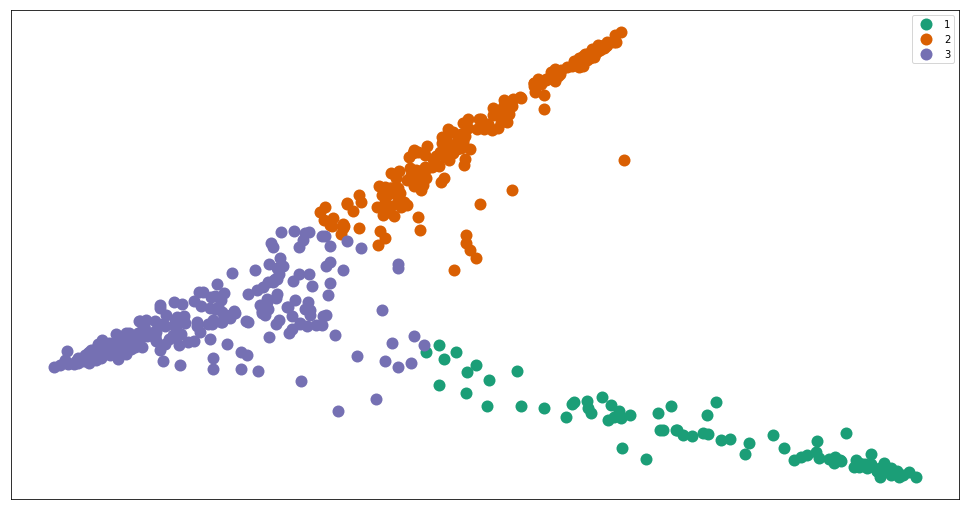

In [142]:
def visualize_clusters(xs, ys, clusters, cluster_names, cluster_colors):
    %matplotlib inline 
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
    groups = df.groupby('label')
    ##TODO
    fig, ax = plt.subplots(figsize=(17, 9))
    ax.margins(0.05) 
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label= cluster_names[name],
                color= cluster_colors[name],
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          
            which='both',      
            bottom='off',      
            top='off',         
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         
            which='both',     
            left='off',     
            top='off',      
            labelleft='off')
    ax.legend(numpoints=1) 
    plt.show() 

visualize_clusters(xs, ys, clusters, cluster_names, cluster_colors)











정리 

위 Clustering은 해당 data의 속성을 vectorize한 결과물을 concatenating 하여 clustering을 진행하였다. 진행함에 있어 속성별 특이점을 찾기 어려웠으므로 모든 데이터에 대한 순차 진행을 통해 가장 좋은 clustering을 선별하였다.

1.Data_processing

속성값을 word에 따른 vectorize를 진행하고 가능한 모든 조합을 계산한다. 단 abstract는 반드시 마지막에 포함하게 처리한다. 이후 이를 SVD화한다.

2.Clustering

cluster의 개수를 3~10개로 변화시키며 silhouette score가 가장 높은 feature의 조합과 cluster의 개수를 선택한다. 매번 클러스터링의 값이 변화하므로 10번 반복하여 가장 높은 값을 사용한다.

3.Visualize

clustering 된 결과를 보면 3개의 군집으로 나위어 확실히 눈에 보이게 구별되어진다.

4.Result

선택된 feature는 10회 모두 [keyword, topics, groups, abstract] 순서의 feature이다.. primary key인 title은 선택된 적이 없으므로 데이터를 clustering 함에 있어 좋은 속성으로 볼 수 없다. 
또한 cluster의 개수는 3개만 선택되었으므로 해당 문서가 3개의 특징으로 구성되있음을 말한다.


additional

아래는 primary key인 title feature를 제외한 결과이다.
아래모델도 동일한 방식으로 진행하였으며 각도만 바뀌어 있을 뿐 feature와 결과물이 유사함을 알 수 있다.
선택된 feature는 [group, keywords, topic, abstract] 순서의 데이터로 순서는 다르지만 모든 feature를 사용한 경우가 가장 효율이 높음을 확인 할 수 있다.

따라서 feature중 primary키를 제외한 데이터를 통해 Clustering을 할 때 3가지의 군집으로 군집화되는 효율이 가장 높음을 알 수 있다.













In [143]:
vector = [group, key_word, topic]

In [144]:
pre_features = []

for i in range(len(vector)+1) :
    for subset in itertools.permutations(vector, i) :
        pre_features.append(subset)

print(len(pre_features))

16


In [145]:
features = []

for feature in pre_features :
    
    if len(feature) == 0 :
        features.append(abstract)
        
    elif len(feature) == 1 :
        features.append(np.concatenate([feature[0], abstract], axis=1))
        continue
    else :
        feature = list(feature)
        feature.append(abstract)
        features.append(np.concatenate(feature, axis=1))

print(len(features))

16


In [146]:
t0 = time()
svd = TruncatedSVD(3)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

for i, feature in enumerate(features) :
    features[i] = lsa.fit_transform(feature)

In [147]:
real_best_cluster_num = 0
real_best_feature = None
real_best_km = None
real_max_score = 0
real_best_feature_num = 0

best_cl_f_list = []

for x in range(10) :
    max_km = None
    best_feature = None
    best_cluster_num = None
    best_feature_num = None
    max_score = 0
    for i, feature in enumerate(features) :
        for cluster_num in range(8) :
            km = KMeans(n_clusters=cluster_num+2, random_state=1).fit(feature)
            label = km.labels_
            score = metrics.silhouette_score(feature, label, metric='euclidean')

            if max_score < score :
                #print(i, cluster_num, score)
                max_score = score
                max_km = km
                best_cluster_num = cluster_num+2
                best_feature = feature
                best_feature_num = i
        
    best_cl_f_list.append([best_feature_num, best_cluster_num])
        
    if real_max_score < max_score :
        real_max_score = score
        real_best_km = max_km
        real_best_cluster_num = best_cluster_num
        real_best_feature = best_feature
        real_best_feature_num = best_feature_num


clusters = real_best_km.labels_.tolist()
print(best_cl_f_list)
print(real_best_cluster_num)
print(real_best_feature_num)

[[10, 3], [10, 3], [10, 3], [10, 3], [10, 3], [10, 3], [10, 3], [10, 3], [10, 3], [10, 3]]
3
10


In [148]:
dist = 1 - cosine_similarity(real_best_feature)
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3:'#003177', 4:'#B70027', 5: '#FF96FF', 6:'#140700', 7:'#008C99', 8:'#C1B400', 9 : '#00FFF2'}
cluster_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

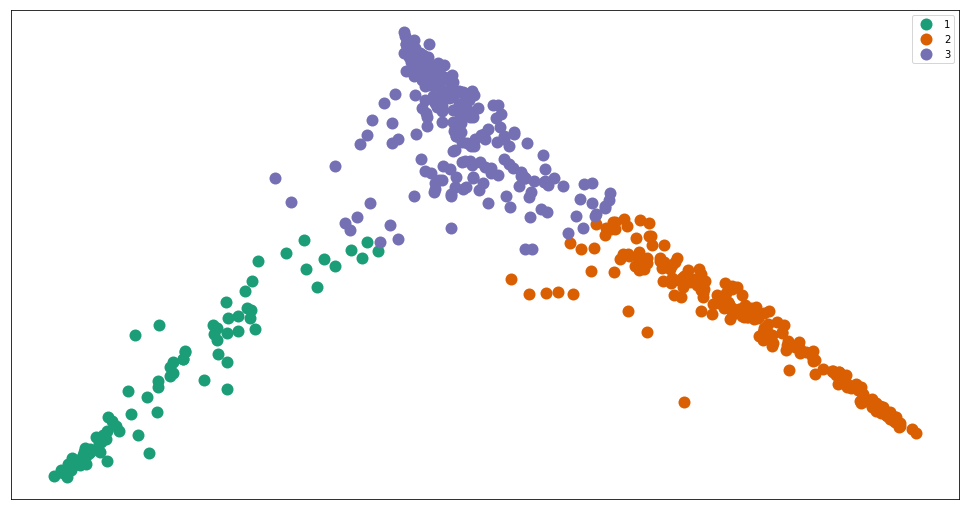

In [149]:
def visualize_clusters(xs, ys, clusters, cluster_names, cluster_colors):
    %matplotlib inline 
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
    groups = df.groupby('label')
    ##TODO
    fig, ax = plt.subplots(figsize=(17, 9))
    ax.margins(0.05) 
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label= cluster_names[name],
                color= cluster_colors[name],
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          
            which='both',      
            bottom='off',      
            top='off',         
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         
            which='both',     
            left='off',     
            top='off',      
            labelleft='off')
    ax.legend(numpoints=1) 
    plt.show() 

visualize_clusters(xs, ys, clusters, cluster_names, cluster_colors)

# FIN
## You did a really good job for the short semester. Have a nice vacation!! :) 